# Setup

In [ ]:
!pip install osfclient --quiet
!pip install git+https://github.com/jspsych/eyetracking-utils.git --quiet
!pip install keras_cv --quiet
!pip install plotnine --quiet
!pip install wandb --quiet
!pip install albumentations --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 54.3 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import numpy as np
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow.keras as keras
import keras_cv
from plotnine import ggplot, geom_point, aes, geom_line, scale_y_reverse, theme_void, scale_color_manual
import pandas as pd
import wandb
from wandb.integration.keras import WandbMetricsLogger
import albumentations as A

import matplotlib.pyplot as plt
from google.colab import userdata



import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.model_analysis import plot_model_performance

In [3]:
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
os.environ['OSF_TOKEN'] = userdata.get('osftoken')
os.environ['OSF_USERNAME'] = userdata.get('osfusername')

In [4]:
keras.mixed_precision.set_global_policy('mixed_float16')

# Configure W&B experiment

In [5]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joshdeleeuw (eye-tracking) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Fixed constants
MAX_TARGETS = 144

# Config constants
EMBEDDING_DIM = 200
RIDGE_REGULARIZATION = 0.1
TRAIN_EPOCHS = 30
MIN_CAL_POINTS = 8
MAX_CAL_POINTS = 40
DENSE_NET_STACKWISE_NUM_REPEATS = [4,4,4]
LEARNING_RATE = 0.001
AUGMENTATION = True

In [7]:
config = {
    "embedding_dim": EMBEDDING_DIM,
    "ridge_regularization": RIDGE_REGULARIZATION,
    "train_epochs": TRAIN_EPOCHS,
    "min_cal_points": MIN_CAL_POINTS,
    "max_cal_points": MAX_CAL_POINTS,
    "dense_net_stackwise_num_repeats": DENSE_NET_STACKWISE_NUM_REPEATS,
    "learning_rate": LEARNING_RATE,
    "augmentation": AUGMENTATION,
}

In [8]:
run = wandb.init(
    project='eye-tracking-dense-full-data-set-single-eye',
    config=config
)

# Download dataset from OSF

In [9]:
!osf -p 6b5cd fetch single_eye_tfrecords.tar.gz

100% 2.50G/2.50G [01:15<00:00, 33.2Mbytes/s]


# Process raw data records into TF Dataset

In [10]:
!mkdir single_eye_tfrecords
!tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [11]:
def parse(element):
    """Process function that parses a tfr element in a raw dataset for process_tfr_to_tfds function.
    Gets mediapipe landmarks, raw image, image width, image height, subject id, and xy labels.
    Use for data generated with make_single_example_landmarks_and_jpg (i.e. data in
    jpg_landmarks_tfrecords.tar.gz)

    :param element: tfr element in raw dataset
    :return: image, label(x,y), landmarks, subject_id
    """

    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    landmarks = content['landmarks']
    raw_image = content['eye_img']
    width = content['img_width']
    height = content['img_height']
    depth = 3
    label = [content['x'], content['y']]
    subject_id = content['subject_id']

    landmarks = tf.io.parse_tensor(landmarks, out_type=tf.float32)
    landmarks = tf.reshape(landmarks, shape=(478, 3))

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, landmarks, label, subject_id

In [12]:
train_data, validation_data, test_data = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, landmarks, coords, z: z
)

## Rescale the `x,y` coordinates to be 0-1 instead of 0-100.

In [13]:
def rescale_coords_map(eyes, mesh, coords, id):
  return eyes, mesh, tf.divide(coords, tf.constant([100.])), id

In [14]:
train_data_rescaled = train_data.map(rescale_coords_map)
validation_data_rescaled = validation_data.map(rescale_coords_map)

# Generate dataset that has calibration points, target point, and target output

In [15]:
def pad_to_fixed_size(tensor, target_shape, pad_value=0):
    """Pad tensor to target shape."""
    current_shape = tf.shape(tensor)
    paddings = tf.maximum(0, target_shape - current_shape)
    padded = tf.pad(tensor, [[0, paddings[0]], [0, paddings[1]], [0, paddings[2]], [0, paddings[3]]])
    # Ensure fixed shape
    padded = tf.ensure_shape(padded, [target_shape[0], target_shape[1], target_shape[2], target_shape[3]])
    return padded

def create_padding_mask(tensor, max_len):
    """Create a mask indicating which elements are padding."""
    actual_len = tf.shape(tensor)[0]
    mask = tf.range(max_len) < actual_len
    return tf.cast(mask, tf.float32)

Cols = 5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95

Rows = 5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95  


Fixed Points as calibration

In [16]:
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

def filter_cal_points(image, mesh, coords, id):

  return tf.reduce_any(tf.reduce_all(tf.equal(coords, scaled_cal_points), axis=1))

def filter_non_cal_points(image, mesh, coords, id):

  return tf.reduce_all(tf.reduce_any(tf.not_equal(coords, scaled_cal_points), axis=1))

def filter_subjects_missing_cal_points(cal, target):

  return tf.equal(tf.shape(cal[0])[0], tf.shape(cal_points)[0])

def map_for_calibration_pts(image, mesh, coords, id):
  img = tf.reshape(image, (-1, 36, 144, 1))

  # No padding here as we'll handle padding in the merged function
  return img, coords

def map_for_non_calibration_pts(image, mesh, coords, id):
  img = tf.reshape(image, (-1, 36, 144, 1))

  # No padding here as we'll handle padding in the merged function
  return img, coords

def map_for_merged(cal, non_cal):
  # Unpack the inputs
  cal_imgs, cal_coords = cal
  target_imgs, target_coords = non_cal

  # Get the sizes
  cal_size = tf.shape(cal_imgs)[0]
  target_size = tf.shape(target_imgs)[0]

  # Create masks
  cal_mask = create_padding_mask(cal_imgs, MAX_CAL_POINTS)
  target_mask = create_padding_mask(target_imgs, MAX_TARGETS)  # Assuming max target points is 144

  # Pad images and coordinates
  padded_cal_imgs = tf.pad(cal_imgs, [[0, MAX_CAL_POINTS - cal_size], [0, 0], [0, 0], [0, 0]])
  padded_cal_coords = tf.pad(cal_coords, [[0, MAX_CAL_POINTS - cal_size], [0, 0]])
  padded_target_imgs = tf.pad(target_imgs, [[0, MAX_TARGETS - target_size], [0, 0], [0, 0], [0, 0]])
  padded_target_coords = tf.pad(target_coords, [[0, MAX_TARGETS - target_size], [0, 0]])

  # Ensure fixed shapes
  padded_cal_imgs = tf.ensure_shape(padded_cal_imgs, [MAX_CAL_POINTS, 36, 144, 1])
  padded_cal_coords = tf.ensure_shape(padded_cal_coords, [MAX_CAL_POINTS, 2])
  padded_target_imgs = tf.ensure_shape(padded_target_imgs, [MAX_TARGETS, 36, 144, 1])
  padded_target_coords = tf.ensure_shape(padded_target_coords, [MAX_TARGETS, 2])

  # Return with masks
  return (padded_cal_imgs, padded_cal_coords, cal_mask, padded_target_imgs, target_mask), padded_target_coords

def map_for_merged_with_id(cal, non_cal, id):
  # Unpack the inputs
  cal_imgs, cal_coords = cal
  target_imgs, target_coords = non_cal

  # Get the sizes
  cal_size = tf.shape(cal_imgs)[0]
  target_size = tf.shape(target_imgs)[0]

  # Create masks
  cal_mask = create_padding_mask(cal_imgs, MAX_CAL_POINTS)
  target_mask = create_padding_mask(target_imgs, MAX_TARGETS)  # Assuming max target points is 144

  # Pad images and coordinates
  padded_cal_imgs = tf.pad(cal_imgs, [[0, MAX_CAL_POINTS - cal_size], [0, 0], [0, 0], [0, 0]])
  padded_cal_coords = tf.pad(cal_coords, [[0, MAX_CAL_POINTS - cal_size], [0, 0]])
  padded_target_imgs = tf.pad(target_imgs, [[0, MAX_TARGETS - target_size], [0, 0], [0, 0], [0, 0]])
  padded_target_coords = tf.pad(target_coords, [[0, MAX_TARGETS - target_size], [0, 0]])

  # Ensure fixed shapes
  padded_cal_imgs = tf.ensure_shape(padded_cal_imgs, [MAX_CAL_POINTS, 36, 144, 1])
  padded_cal_coords = tf.ensure_shape(padded_cal_coords, [MAX_CAL_POINTS, 2])
  padded_target_imgs = tf.ensure_shape(padded_target_imgs, [MAX_TARGETS, 36, 144, 1])
  padded_target_coords = tf.ensure_shape(padded_target_coords, [MAX_TARGETS, 2])

  # Return with masks
  return (padded_cal_imgs, padded_cal_coords, cal_mask, padded_target_imgs, target_mask), padded_target_coords, id

def reducer_function(k, ds):
  ds_random = ds.shuffle(MAX_TARGETS)

  n_cal_points = tf.random.uniform(shape=[], minval=MIN_CAL_POINTS, maxval=MAX_CAL_POINTS, dtype=tf.int64)

  calibration_points = ds_random.take(n_cal_points).batch(n_cal_points).map(map_for_calibration_pts).repeat()

  non_calibration_points = ds.batch(MAX_TARGETS).map(map_for_non_calibration_pts)

  merged = tf.data.Dataset.zip(calibration_points, non_calibration_points)
  return merged.map(map_for_merged)

# group data by subject id, create datasets with calibration points
def reducer_function_fixed_pts(subject_id, ds):
  non_cal_points = ds.batch(MAX_TARGETS, drop_remainder=True).map(map_for_non_calibration_pts)

  points = ds.filter(filter_cal_points).batch(len(cal_points), drop_remainder=True).map(map_for_calibration_pts).repeat()

  merged = tf.data.Dataset.zip(points, non_cal_points)
  return merged.map(map_for_merged)

def reducer_function_fixed_pts_with_id(subject_id, ds):
  non_cal_points = ds.batch(MAX_TARGETS, drop_remainder=True).map(map_for_non_calibration_pts)

  points = ds.filter(filter_cal_points).batch(len(cal_points)).map(map_for_calibration_pts).repeat()

  merged = tf.data.Dataset.zip(points, non_cal_points)

  return merged.map(lambda x, y: map_for_merged_with_id(x, y, subject_id))

## Create augmentation pipeline

In [ ]:
# Define augmentation pipeline
def create_augmentation_pipeline():
    return A.ReplayCompose([
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.7),
        A.Rotate(limit=2, p=0.7, border_mode=0),
        A.Affine(
            scale=(0.98, 1.02),
            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
            p=0.7,
            border_mode=0
        ),
        A.GaussNoise(var_limit=(0.001, 0.01), p=0.5),
        A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0),
    ])

aug_pipeline = create_augmentation_pipeline()

def apply_consistent_augmentations(x, y):
    """Apply identical augmentations to all images in calibration and target sets"""
    cal_imgs, cal_coords, cal_mask, target_imgs, target_mask = x
    
    # Convert to numpy for Albumentations (which doesn't work directly with TF tensors)
    cal_imgs_np = cal_imgs.numpy()
    target_imgs_np = target_imgs.numpy()
    
    batch_size = cal_imgs_np.shape[0]
    cal_points = cal_imgs_np.shape[1]
    target_points = target_imgs_np.shape[1]
    height = cal_imgs_np.shape[2]
    width = cal_imgs_np.shape[3]
    channels = cal_imgs_np.shape[4]
    
    # Create output arrays
    cal_imgs_aug = np.zeros_like(cal_imgs_np)
    target_imgs_aug = np.zeros_like(target_imgs_np)
    
    # Process each sample in batch
    for b in range(batch_size):
        # For each batch, generate ONE set of random parameters
        # Apply to first image and capture the transformation parameters
        first_img = cal_imgs_np[b, 0]
        transformed = aug_pipeline(image=first_img)
        replay_data = transformed['replay']
        
        # Apply the exact same transformation to all calibration images
        for i in range(cal_points):
            if cal_mask[b, i] > 0:  # Only process valid images (not padding)
                img = cal_imgs_np[b, i]
                # Apply the saved transformation
                augmented = A.ReplayCompose.replay(replay_data, image=img)
                cal_imgs_aug[b, i] = augmented['image']
        
        # Apply the exact same transformation to all target images
        for i in range(target_points):
            if target_mask[b, i] > 0:  # Only process valid images
                img = target_imgs_np[b, i]
                # Apply the saved transformation
                augmented = A.ReplayCompose.replay(replay_data, image=img)
                target_imgs_aug[b, i] = augmented['image']
    
    # Convert back to TensorFlow tensors
    return (tf.convert_to_tensor(cal_imgs_aug), cal_coords, cal_mask, 
            tf.convert_to_tensor(target_imgs_aug), target_mask), y

# Use tf.py_function to wrap the numpy-based function
def apply_consistent_augmentations_wrapper(x, y):
    return tf.py_function(
        func=apply_consistent_augmentations,
        inp=[x, y],
        Tout=[
            (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
            tf.float32
        ]
    )


In [ ]:
t0 = train_data_rescaled.cache()

t1 = t0.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function,
    window_size = 200
).prefetch(tf.data.AUTOTUNE)

t2 = t0.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function_fixed_pts_with_id,
    window_size = 200
)

# Apply to dataset - ensure consistent shapes
train_ds = t1.map(
    apply_consistent_augmentations_wrapper,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

# Update the batching step to use a custom padded_batch function
def prepare_batch_for_model(features, labels):
    """Ensure inputs are correctly formatted for the model"""
    cal_imgs, cal_coords, cal_mask, target_imgs, target_mask = features

    # Prepare inputs as a dictionary matching the model's expected inputs
    inputs = {
        "Input_Calibration_Eyes": cal_imgs,
        "Input_Calibration_Points": cal_coords,
        "Input_Calibration_Mask": cal_mask,
        "Input_Target_Eyes": target_imgs,
        "Input_Target_Mask": target_mask
    }

    return inputs, labels

# Use the updated version with proper input preparation
train_ds_for_model = train_ds.map(prepare_batch_for_model).prefetch(tf.data.AUTOTUNE)


In [19]:
train_ds_for_model.element_spec

({'Input_Calibration_Eyes': TensorSpec(shape=(40, 36, 144, 1), dtype=tf.float16, name=None),
  'Input_Calibration_Points': TensorSpec(shape=(40, 2), dtype=tf.float32, name=None),
  'Input_Calibration_Mask': TensorSpec(shape=(40,), dtype=tf.float32, name=None),
  'Input_Target_Eyes': TensorSpec(shape=(144, 36, 144, 1), dtype=tf.float16, name=None),
  'Input_Target_Mask': TensorSpec(shape=(144,), dtype=tf.float32, name=None)},
 TensorSpec(shape=(144, 2), dtype=tf.float32, name=None))

## Visualize augmentation

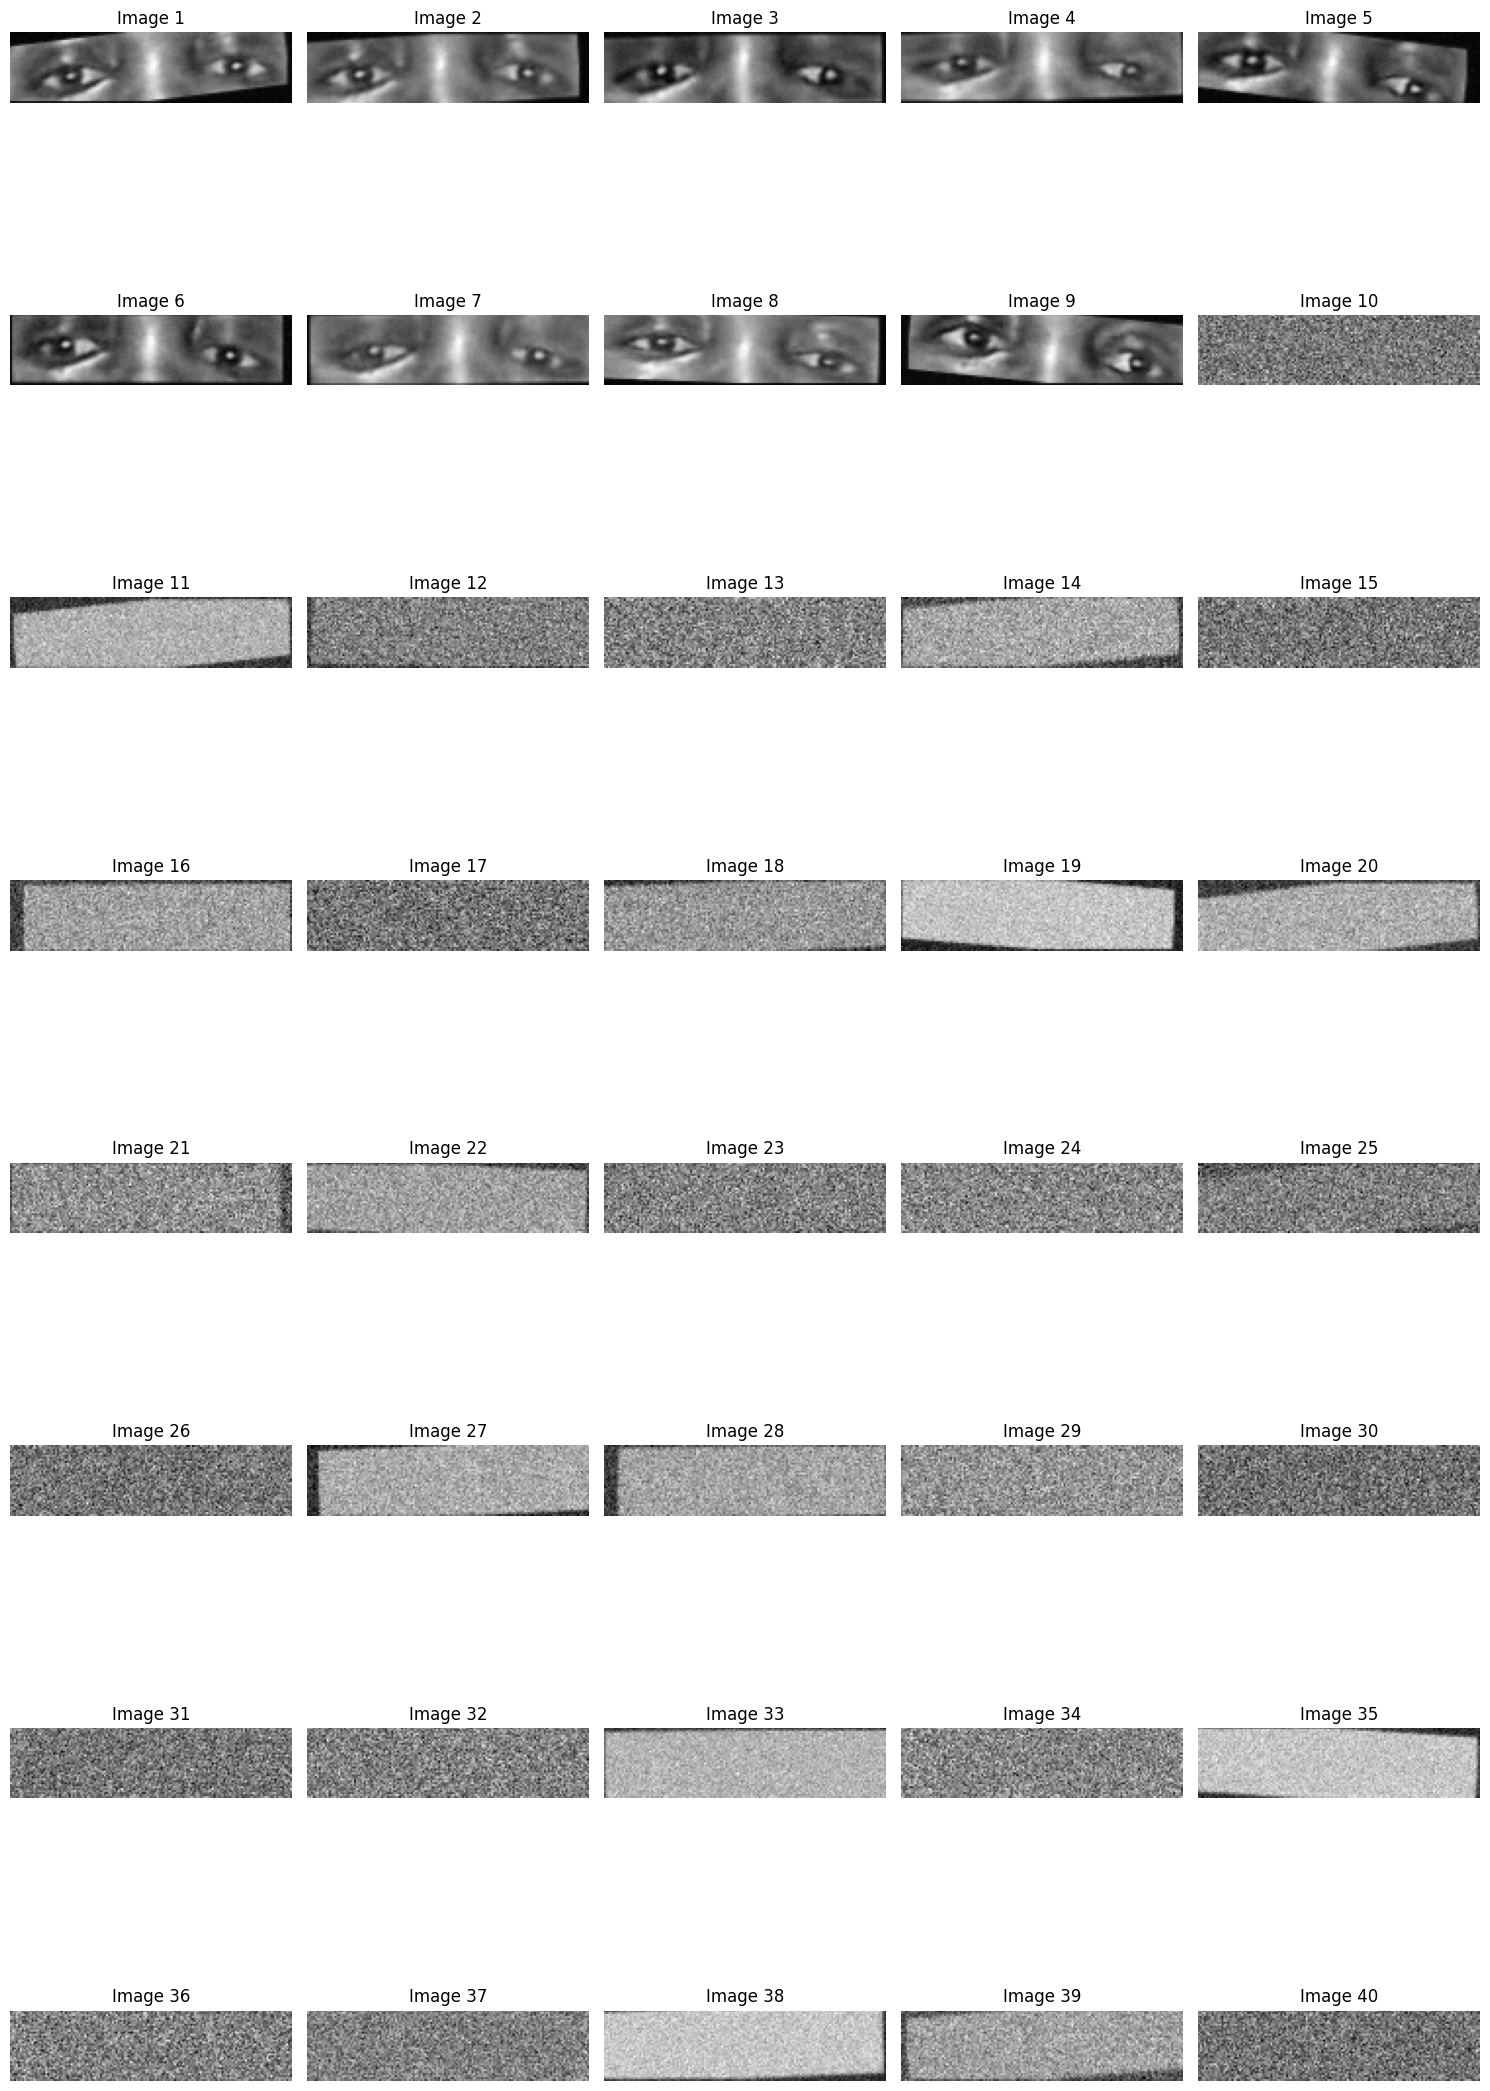

In [20]:
def visualize_augmentations(dataset, num_examples=5):
    """Visualize augmentations from a tf.data.Dataset."""

    # Get a sample element from the dataset
    for element in dataset.take(1):
        # Access the calibration images from the element
        images = element[0][0]  # Access all calibration images

    # Calculate grid dimensions
    num_images = images.shape[0]  # Get the number of images in the batch
    grid_cols = 5  # Number of columns in the grid
    grid_rows = (num_images + grid_cols - 1) // grid_cols  # Calculate number of rows

    # Create a figure to display results
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 3 * grid_rows))  # Create subplots in a grid

    # Display all images
    for i in range(num_images):
        row = i // grid_cols
        col = i % grid_cols
        axes[row, col].imshow(images[i].numpy().squeeze(), cmap='gray')  # Display image
        axes[row, col].set_title(f"Image {i + 1}")  # Set title for each subplot
        axes[row, col].axis('off')  # Turn off axis

    # Hide empty subplots if any
    for i in range(num_images, grid_rows * grid_cols):
        row = i // grid_cols
        col = i % grid_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Use this to check your augmentations
visualize_augmentations(train_ds)

# Construct Model



## Eye image processing

In [68]:
def create_embedding_model():
    input_eyes = keras.layers.Input(shape=(36,144,1))

    # Continue with the backbone
    backbone = keras_cv.models.DenseNetBackbone(
        include_rescaling=False,
        input_shape=(36,144,1),
        stackwise_num_repeats=DENSE_NET_STACKWISE_NUM_REPEATS
    )
    backbone_encoder = backbone(input_eyes)

    flatten_compress = keras.layers.Flatten()(backbone_encoder)
    eye_embedding = keras.layers.Dense(units=EMBEDDING_DIM, activation="tanh")(flatten_compress)

    embedding_model = keras.Model(inputs=input_eyes, outputs=eye_embedding, name="Eye_Image_Embedding")

    return embedding_model

## Regression Layer

In [69]:
class WeightedRidgeRegressionLayer(keras.layers.Layer):
    def __init__(self, lambda_ridge, epsilon=1e-6, **kwargs):
        self.lambda_ridge = lambda_ridge
        self.epsilon = epsilon
        super(WeightedRidgeRegressionLayer, self).__init__(**kwargs)

    @tf.function(jit_compile=True)
    def call(self, inputs):
        unknown_embeddings, calibration_embeddings, calibration_coords, weights, cal_mask, target_mask = inputs

        X = tf.cast(calibration_embeddings, tf.float32)  # (batch_size, n_calibration, embedding_dim)
        y = tf.cast(calibration_coords, tf.float32)  # (batch_size, n_calibration, 2)
        w = tf.cast(weights, tf.float32)  # (batch_size, n_calibration)
        cal_mask = tf.cast(cal_mask, tf.float32)  # (batch_size, n_calibration)
        target_mask = tf.cast(target_mask, tf.float32)  # (batch_size, n_target)

        # Apply mask to weights
        w = w * cal_mask

        # Compute weighted ridge regression coefficients
        n, p = tf.shape(X)[-2], tf.shape(X)[-1]  # n_calibration, embedding_dim
        I = tf.eye(p, dtype=X.dtype)

        # Apply weights to X and y
        w_sqrt = tf.sqrt(w)
        X_weighted = X * tf.expand_dims(w_sqrt, axis=-1)  # (batch_size, n_calibration, embedding_dim)
        y_weighted = y * tf.expand_dims(w_sqrt, axis=-1)  # (batch_size, n_calibration, 2)

        X_t = tf.transpose(X_weighted, perm=[0, 2, 1])  # (batch_size, embedding_dim, n_calibration)
        X_t_X = tf.linalg.matmul(X_t, X_weighted)  # (batch_size, embedding_dim, embedding_dim)
        lhs = X_t_X + (self.lambda_ridge + self.epsilon) * I  # (batch_size, embedding_dim, embedding_dim)
        rhs = tf.linalg.matmul(X_t, y_weighted)  # (batch_size, embedding_dim, 2)

        kernel = tf.linalg.solve(lhs, rhs)  # (batch_size, embedding_dim, 2)

        # Apply regression to unknown point and mask
        unknown_embeddings = tf.cast(unknown_embeddings, tf.float32)

        # Apply mask to unknown embeddings
        unknown_embeddings_masked = unknown_embeddings * tf.expand_dims(target_mask, axis=-1)

        output = tf.linalg.matmul(unknown_embeddings_masked, tf.transpose(kernel, perm=[0, 2, 1]), adjoint_b=True)  # (batch_size, n_target, 2)

        # Ensure padded outputs don't contribute to loss
        output = output * tf.expand_dims(target_mask, axis=-1)  # Zero out predictions for padded inputs

        return output

    def compute_output_shape(self, input_shapes):
        unknown_embeddings_shape, _, _, _, _, _ = input_shapes
        return unknown_embeddings_shape[:-1] + (2,)

    def get_config(self):
        config = super(WeightedRidgeRegressionLayer, self).get_config()
        config.update({"lambda_ridge": self.lambda_ridge, "epsilon": self.epsilon})
        return config

In [70]:
def create_full_model():

  embedding_model = create_embedding_model()

  input_calibration_eyes = keras.layers.Input(shape=(MAX_CAL_POINTS, 36, 144, 1), name="Input_Calibration_Eyes")
  input_calibration_points = keras.layers.Input(shape=(MAX_CAL_POINTS, 2), name="Input_Calibration_Points")
  input_calibration_mask = keras.layers.Input(shape=(MAX_CAL_POINTS,), name="Input_Calibration_Mask")

  input_target_eyes = keras.layers.Input(shape=(144, 36, 144, 1), name="Input_Target_Eyes")
  input_target_mask = keras.layers.Input(shape=(144,), name="Input_Target_Mask")

  # Apply the embedding model using masking
  target_embedding = keras.layers.TimeDistributed(embedding_model)(input_target_eyes)
  calibration_embeddings = keras.layers.TimeDistributed(embedding_model)(input_calibration_eyes)

  calibration_weights = keras.layers.Dense(1, activation="sigmoid", name="Calibration_Weights")(calibration_embeddings)
  calibration_weights_reshaped = keras.layers.Reshape((-1,), name="Calibration_Weights_Reshaped")(calibration_weights)

  ridge = WeightedRidgeRegressionLayer(RIDGE_REGULARIZATION)([
    target_embedding,
    calibration_embeddings,
    input_calibration_points,
    calibration_weights_reshaped,
    input_calibration_mask,
    input_target_mask
  ])

  full_model = keras.Model(inputs=[
    input_calibration_eyes,
    input_calibration_points,
    input_calibration_mask,
    input_target_eyes,
    input_target_mask
  ], outputs=ridge, name="FullEyePredictionModel")

  return full_model

## Full trainable model

In [71]:
full_model = create_full_model()

full_model.summary()

def masked_normalized_weighted_euc_dist(y_true, y_pred):
    """Custom loss function that calculates a weighted Euclidean distance between two sets of points,
    respecting masks for padded sequences.

    Weighting multiplies the x-coordinate of each input by 1.778 (derived from the 16:9 aspect ratio of most laptops)
    to match the scale of the y-axis. For interpretability, the distances are normalized to the diagonal
    such that the maximum distance between two points (corner to corner) is 100.

    :param y_true (tensor): A tensor of shape (batch_size, seq_len, 2) containing ground-truth x- and y- coordinates
    :param y_pred (tensor): A tensor of shape (batch_size, seq_len, 2) containing predicted x- and y- coordinates

    :returns: A tensor of shape (1,) with the weighted and normalized euclidean distances between valid points.
    """
    # Extract shape information
    batch_size = tf.shape(y_true)[0]
    seq_len = tf.shape(y_true)[1]

    # Create a mask based on zero-padding in y_pred
    # Assuming padded values are exactly 0 in both dimensions
    mask = tf.reduce_any(tf.not_equal(y_pred, 0), axis=-1)
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Weighting treats y-axis as unit-scale and creates a rectangle that's 177.8x100 units.
    x_weight = tf.constant([1.778, 1.0], dtype=tf.float32)

    # Multiply x-coordinate by 16/9 = 1.778
    y_true_weighted = tf.math.multiply(x_weight, y_true)
    y_pred_weighted = tf.math.multiply(x_weight, y_pred)

    # Calculate Euclidean distance with weighted coordinates
    squared_diff = tf.math.square(y_pred_weighted - y_true_weighted)
    squared_dist = tf.math.reduce_sum(squared_diff, axis=-1)
    dist = tf.math.sqrt(squared_dist)

    # Euclidean Distance from [0,0] to [177.8, 100] = 203.992
    norm_scale = tf.constant(203.992, dtype=tf.float32)

    # Normalizes loss values to the diagonal-- makes loss easier to interpret
    normalized_dist = (dist / norm_scale) * 100

    # Apply mask to only include valid points in the loss calculation
    masked_dist = normalized_dist * mask

    # Sum the losses and divide by the number of non-padded elements
    num_valid = tf.maximum(tf.reduce_sum(mask), 1.0)  # Avoid division by zero
    loss = tf.reduce_sum(masked_dist) / num_valid

    return loss

full_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=masked_normalized_weighted_euc_dist,
    metrics=[normalized_weighted_euc_dist],  # Keep the original for comparison if needed
    jit_compile=False
)

Model: "FullEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Calibration_Eyes    │ (None, 40, 36, 144, 1) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_20 (Cast)            │ (None, 40, 36, 144, 1) │              0 │ Input_Calibration_Eye… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Target_Eyes         │ (None, 144, 36, 144,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_9        │ (None, 40, 200)        │      1,581,896 │ cast_20[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_19 (Cast)            │ (None, 144, 36, 144,   │              0 │ Input_Target_Eyes[0][… │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Calibration_Points  │ (None, 40, 2)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Calibration_Weights       │ (None, 40, 1)          │            201 │ time_distributed_9[0]… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Calibration_Mask    │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Target_Mask         │ (None, 144)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_8        │ (None, 144, 200)       │      1,581,896 │ cast_19[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_21 (Cast)            │ (None, 40, 2)          │              0 │ Input_Calibration_Poi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Calibration_Weights_Resh… │ (None, 40)             │              0 │ Calibration_Weights[0… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_22 (Cast)            │ (None, 40)             │              0 │ Input_Calibration_Mas… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_23 (Cast)            │ (None, 144)            │              0 │ Input_Target_Mask[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ weighted_ridge_regres

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

In [72]:
def lr_schedule(epoch):
  if epoch < 15:
    return LEARNING_RATE
  else:
    return LEARNING_RATE * 0.1

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# Train model

In [73]:
train_history = full_model.fit(
    train_ds_for_model.batch(8),
    epochs=TRAIN_EPOCHS,
    callbacks=[WandbMetricsLogger(), lr_scheduler]
)

Epoch 1/30
      1/Unknown 1702s 1702s/step - loss: 0.2676 - normalized_weighted_euc_dist: 0.2676

InvalidArgumentError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-73-9371d5c51e6b>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-73-9371d5c51e6b>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 5. First element had shape [144,2] and element 1 had shape [143,2].
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
  (1) INVALID_ARGUMENT:  Cannot batch tensors with different shapes in component 5. First element had shape [144,2] and element 1 had shape [143,2].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_1527189]

In [ ]:
full_model.save('full_model.keras')

In [ ]:
full_model.save_weights('full_model.weights.h5')

In [ ]:
wandb.save('full_model.keras')
wandb.save('full_model.weights.h5')

['/content/wandb/run-20241221_135150-2rlxy5dx/files/full_model.weights.h5']

In [ ]:
# Update the prediction code
t2_processed = t2.map(
    lambda x, y, id: (prepare_batch_for_model((x[0], x[1], x[2], x[3], x[4]), y)[0], y, id)
).prefetch(tf.data.AUTOTUNE)

# Initialize a list to store the batch losses
batch_losses = []
subject_ids = []
y_true = []

for e in t2_processed.batch(1).as_numpy_iterator():
    inputs = e[0]
    y_true.append(e[1])
    subject_ids.append(e[2][0])

y_true = np.array(y_true).reshape(-1, 144, 2)

# this step is slower than expected. not sure what's going on.
predictions = full_model.predict(t2_processed.batch(1))

for i in range(len(predictions)):
  loss = normalized_weighted_euc_dist(y_true[i], predictions[i]).numpy()
  batch_losses.append(loss)

batch_losses = np.array(batch_losses)

# Get mean per subject
batch_losses = np.mean(batch_losses, axis=1)

1564/1564 ━━━━━━━━━━━━━━━━━━━━ 807s 421ms/step


In [ ]:
final_loss_table = wandb.Table(data=[[s, l] for (s, l) in zip(subject_ids, batch_losses)], columns=["subject", "scores"])

In [ ]:
final_loss_hist = wandb.plot.histogram(final_loss_table, "scores", title="Normalized Euclidean Distance")

In [ ]:
final_loss_mean = np.mean(batch_losses)

In [ ]:
wandb.log({"final_val_loss_table": final_loss_table, "final_val_loss_hist": final_loss_hist, "final_loss_mean": final_loss_mean})

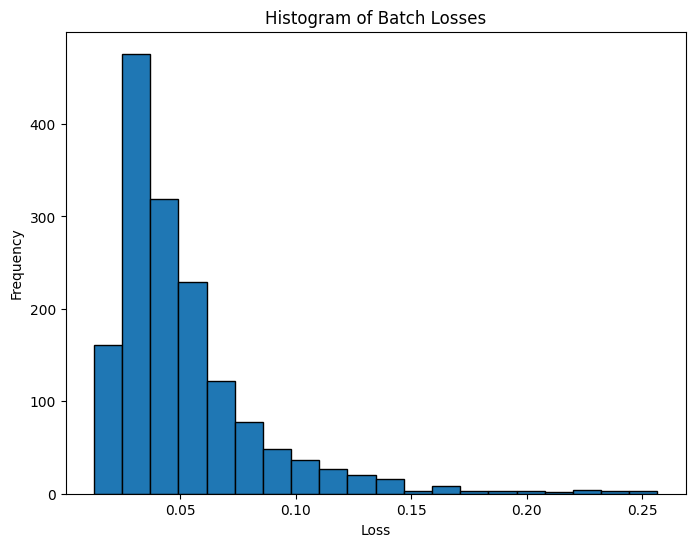

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(batch_losses, bins=20, edgecolor='black')
plt.title('Histogram of Batch Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

In [ ]:
wandb.finish()

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,███████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/normalized_weighted_euc_dist,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_loss_mean,▁
epoch/epoch,29
epoch/learning_rate,0.0001
epoch/loss,0.04859
epoch/normalized_weighted_euc_dist,0.04859
final_loss_mean,0.05181
